In [4]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.utils as dsutils 
import deepgeo.common.geofunctions as gf
import deepgeo.networks.model_builder as mb

reload(dtaug)
reload(dsutils)
reload(mb)
reload(gf)

<module 'deepgeo.common.geofunctions' from '../src/deepgeo/common/geofunctions.py'>

# Load input Dataset

In [5]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../', 'data_real', 'generated')
network = 'unet'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
DATASET_FILE = os.path.join(DATA_DIR, 'new_dataset_286x286_timesstack-2013-2017.npz')

# model_dir = os.path.join(DATA_DIR, 'tf_logs', network,
#                          'test_%s_%s' % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
# model_dir = '/home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug'
model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet', 'test_unet_29_04_2019-12_51_06')

In [6]:
# !rm -rf {model_dir}/*
# !ls -al {model_dir}

# Split dataset between train, test and validation data

In [7]:
dataset = np.load(DATASET_FILE)

print("Data Loaded:")
print("  -> Images: ", len(dataset["images"]))
print("  -> Labels: ", len(dataset["labels"]))
print("  -> Classes: ", len(dataset["classes"]))

print("Images shape: ", dataset["images"][0].shape, " - DType: ", dataset["images"][0].dtype)
print("Labels shape: ", dataset["labels"][0].shape, " - DType: ", dataset["labels"][0].dtype)
print('Classes: ', dataset['classes'])
# print("UNIQUE LABELS: ", np.unique(dataset["labels"]))

Data Loaded:
  -> Images:  7872
  -> Labels:  7872
  -> Classes:  3
Images shape:  (286, 286, 10)  - DType:  float32
Labels shape:  (286, 286, 1)  - DType:  int32
Classes:  ['no_data' 'not_deforestation' 'deforestation']


In [8]:
train_images, test_images, valid_images, train_labels, test_labels, valid_labels = dsutils.split_dataset(dataset,
                                                                                                         perc_test=20,
                                                                                                         perc_val=20)

print("Splitted dataset:")
print("  -> Train images: ", train_images.shape)
print("  -> Test images: ", test_images.shape)
print("  -> Validation images: ", valid_images.shape)
print("  -> Train Labels: ", train_labels.shape)
print("  -> Test Labels: ", test_labels.shape)
print("  -> Validation Labels: ", valid_labels.shape)
total_train_chips = train_images.shape[0]

Splitted dataset:
  -> Train images:  (4723, 286, 286, 10)
  -> Test images:  (1574, 286, 286, 10)
  -> Validation images:  (1575, 286, 286, 10)
  -> Train Labels:  (4723, 286, 286, 1)
  -> Test Labels:  (1574, 286, 286, 1)
  -> Validation Labels:  (1575, 286, 286, 1)


# Perform Data Augmentation

In [6]:
angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images(train_images, angles)
flipped_imgs = dtaug.flip_images(train_images)

train_images = np.concatenate((train_images, rotated_imgs, flipped_imgs))
# train_images = np.concatenate((train_images, ))

rotated_lbls = dtaug.rotate_images(train_labels, angles)
flipped_lbls = dtaug.flip_images(train_labels)

train_labels = np.concatenate((train_labels, rotated_lbls, flipped_lbls))
# train_labels = np.concatenate((train_labels, )).astype(dtype=np.int32)

print('Data Augmentation Applied:')
print('  -> Train Images: ', train_images.shape)
print('  -> Train Labels: ', train_labels.shape)
print('  -> Test Images: ', test_images.shape)
print('  -> Test Labels: ', test_labels.shape)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Data Augmentation Applied:
  -> Train Images:  (38570, 286, 286, 10)
  -> Train Labels:  (38570, 286, 286, 1)
  -> Test Images:  (2362, 286, 286, 10)
  -> Test Labels:  (2362, 286, 286, 1)


In [12]:
def compute_weights_mean_proportion(batch_array, classes, classes_zero=['no_data']):
    values, count = np.unique(batch_array, return_counts=True)
    count = [count[i] if classes[i] not in classes_zero else 0 for i in range(0, len(count))]
    total = sum(count)
    proportions = [i / total for i in count]
    mean_prop = sum(proportions)/ (len(proportions) - len(classes_zero))
    weights = [mean_prop / i if i != 0 else 0 for i in proportions]
    return weights

weights = compute_weights_mean_proportion(train_labels, dataset['classes'])

[0. 1. 2.] [ 718610669 2423074136   13186915]
count: [0, 2423074136, 13186915]
total: 2436261051
proportions: [0.0, 0.994587232351563, 0.005412767648437031]
mean_prop:  0.5
weights: [0, 0.5027211125743286, 92.37418497806348]


## Plot chips to check Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2160x2160 with 0 Axes>

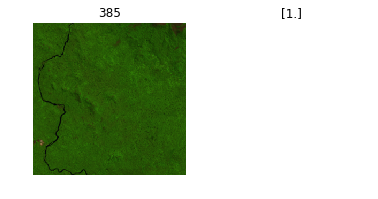

<Figure size 2160x2160 with 0 Axes>

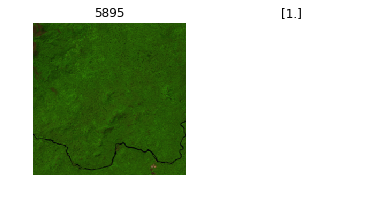

<Figure size 2160x2160 with 0 Axes>

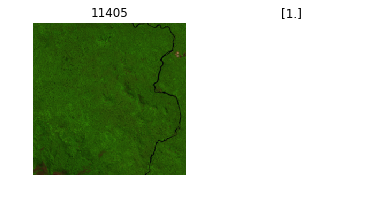

<Figure size 2160x2160 with 0 Axes>

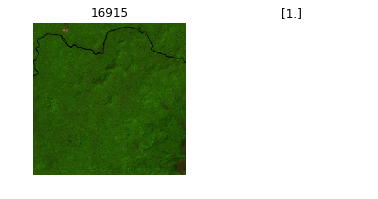

<Figure size 2160x2160 with 0 Axes>

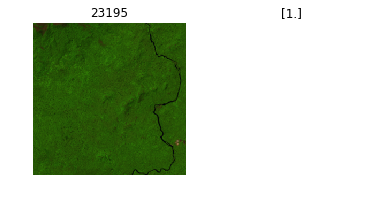

<Figure size 2160x2160 with 0 Axes>

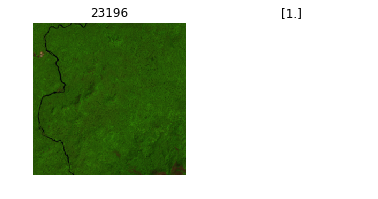

<Figure size 2160x2160 with 0 Axes>

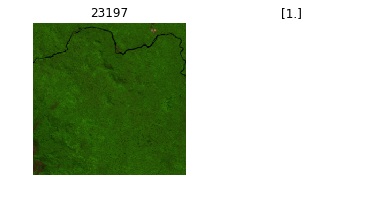

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

def plot_chips_and_labels(imgs, lbls, pos):
    plt.figure(figsize=(30,30))
    plt.subplots(nrows=10, ncols=10)
    count = 1
    plt.subplot(1, 2, count)
    plt.title(str(pos))
    plt.axis('off')
    count += 1
    plt.imshow(imgs[pos][:,:,[8, 7, 6]], interpolation='nearest')

    colorMap = ListedColormap(['white', 'green', 'red'])
    plt.subplot(1, 2, count)
    #     plt.title('pos %d' % (pos))
    plt.title(str(np.unique(lbls[pos])))
    plt.axis('off')
    count += 1
    plt.imshow(lbls[pos][:,:,0], interpolation='nearest', cmap=colorMap)


pos = random.randrange(0, total_train_chips)
pos_1 = pos

plot_chips_and_labels(train_images, train_labels, pos)
pos += total_train_chips
plot_chips_and_labels(train_images, train_labels, pos)
pos += total_train_chips
plot_chips_and_labels(train_images, train_labels, pos)
pos += total_train_chips
plot_chips_and_labels(train_images, train_labels, pos)
pos += ((total_train_chips - pos_1) + (3 * pos_1))
plot_chips_and_labels(train_images, train_labels, pos)
pos += 1
plot_chips_and_labels(train_images, train_labels, pos)
pos += 1
plot_chips_and_labels(train_images, train_labels, pos)

In [ ]:
values, count = np.unique(train_labels, return_counts=True)
print("UNIQUE: ", values, count)

defor_proportion = count[1] / (count[0] + count[1])
non_defor_proportion = count[0] / (count[0] + count[1])
print('Deforestation Proportion: ', defor_proportion)
print('Non deforestation Proportion: ', non_defor_proportion)

print('Ratio: ', non_defor_proportion / defor_proportion)

In [ ]:
mean_proportion = (defor_proportion + non_defor_proportion) / 2
print("Median Proportion: ", mean_proportion)
weight_defor = mean_proportion / defor_proportion
weight_non_defor = mean_proportion / non_defor_proportion

print('Weights: [', weight_defor, ', ', weight_non_defor, ']')

# Train the Network

In [37]:
params = {
    'epochs': 600,
    'batch_size': 100,
    'learning_rate': 0.1,
    'learning_rate_decay': True,
    'decay_rate': 0.1,
    'decay_steps': 245,
    'l2_reg_rate': 0.5,
    'var_scale_factor': 2.0,
    'chips_tensorboard': 2,
    'dropout_rate': 0.5,
    'fusion': 'early',
    'loss_func': 'weighted_crossentropy',
    'class_weights': [0.01, 0.99],
    'num_classes': len(dataset['classes']),
    'class_names': dataset['classes'],
     'bands_plot': [6, 7, 8]
}
reload(mb)
model = mb.ModelBuilder(network)

In [ ]:
model.train(train_images, test_images, train_labels, test_labels, params, model_dir)

In [38]:
model.validate(valid_images, valid_labels, params, model_dir)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/Dados/generated/tf_logs/experiments/unet/test_unet_29_04_2019-12_51_06/model.ckpt-96500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


RuntimeError: Graph is finalized and cannot be modified.